In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import json
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
from keras import backend as K
# from tensorflow.keras.metrics import DiceCoefficient

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
model_builder = keras.applications.xception.Xception
img_size = (128, 128)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path =  "/content/drive/MyDrive/Dataset/Elephant.png"


display(Image(img_path))

In [8]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [9]:


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]



    # Comparing prediction and conv_output
        if preds.shape == last_conv_layer_output.shape:
    # Compare each element of predictions with conv_outputs
          if np.array_equal(preds, last_conv_layer_output):
              print("predictions and conv_outputs are the same")
          else:
              print("predictions and conv_outputs are different")
        else:
            print("predictions and conv_outputs have different shapes")



    # # This is the gradient of the output neuron (top predicted or chosen)
    # # with regard to the output feature map of the last conv layer
    # grads = tape.gradient(class_channel, last_conv_layer_output)

    # # This is a vector where each entry is the mean intensity of the gradient
    # # over a specific feature map channel
    # pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # # We multiply each channel in the feature map array
    # # by "how important this channel is" with regard to the top predicted class
    # # then sum all the channels to obtain the heatmap class activation
    # last_conv_layer_output = last_conv_layer_output[0]
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # heatmap = tf.squeeze(heatmap)

    # # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    # return heatmap.numpy()

In [10]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()

91884032/91884032 [==============================] - 1s 0us/step


ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(1, 128, 128, 3)

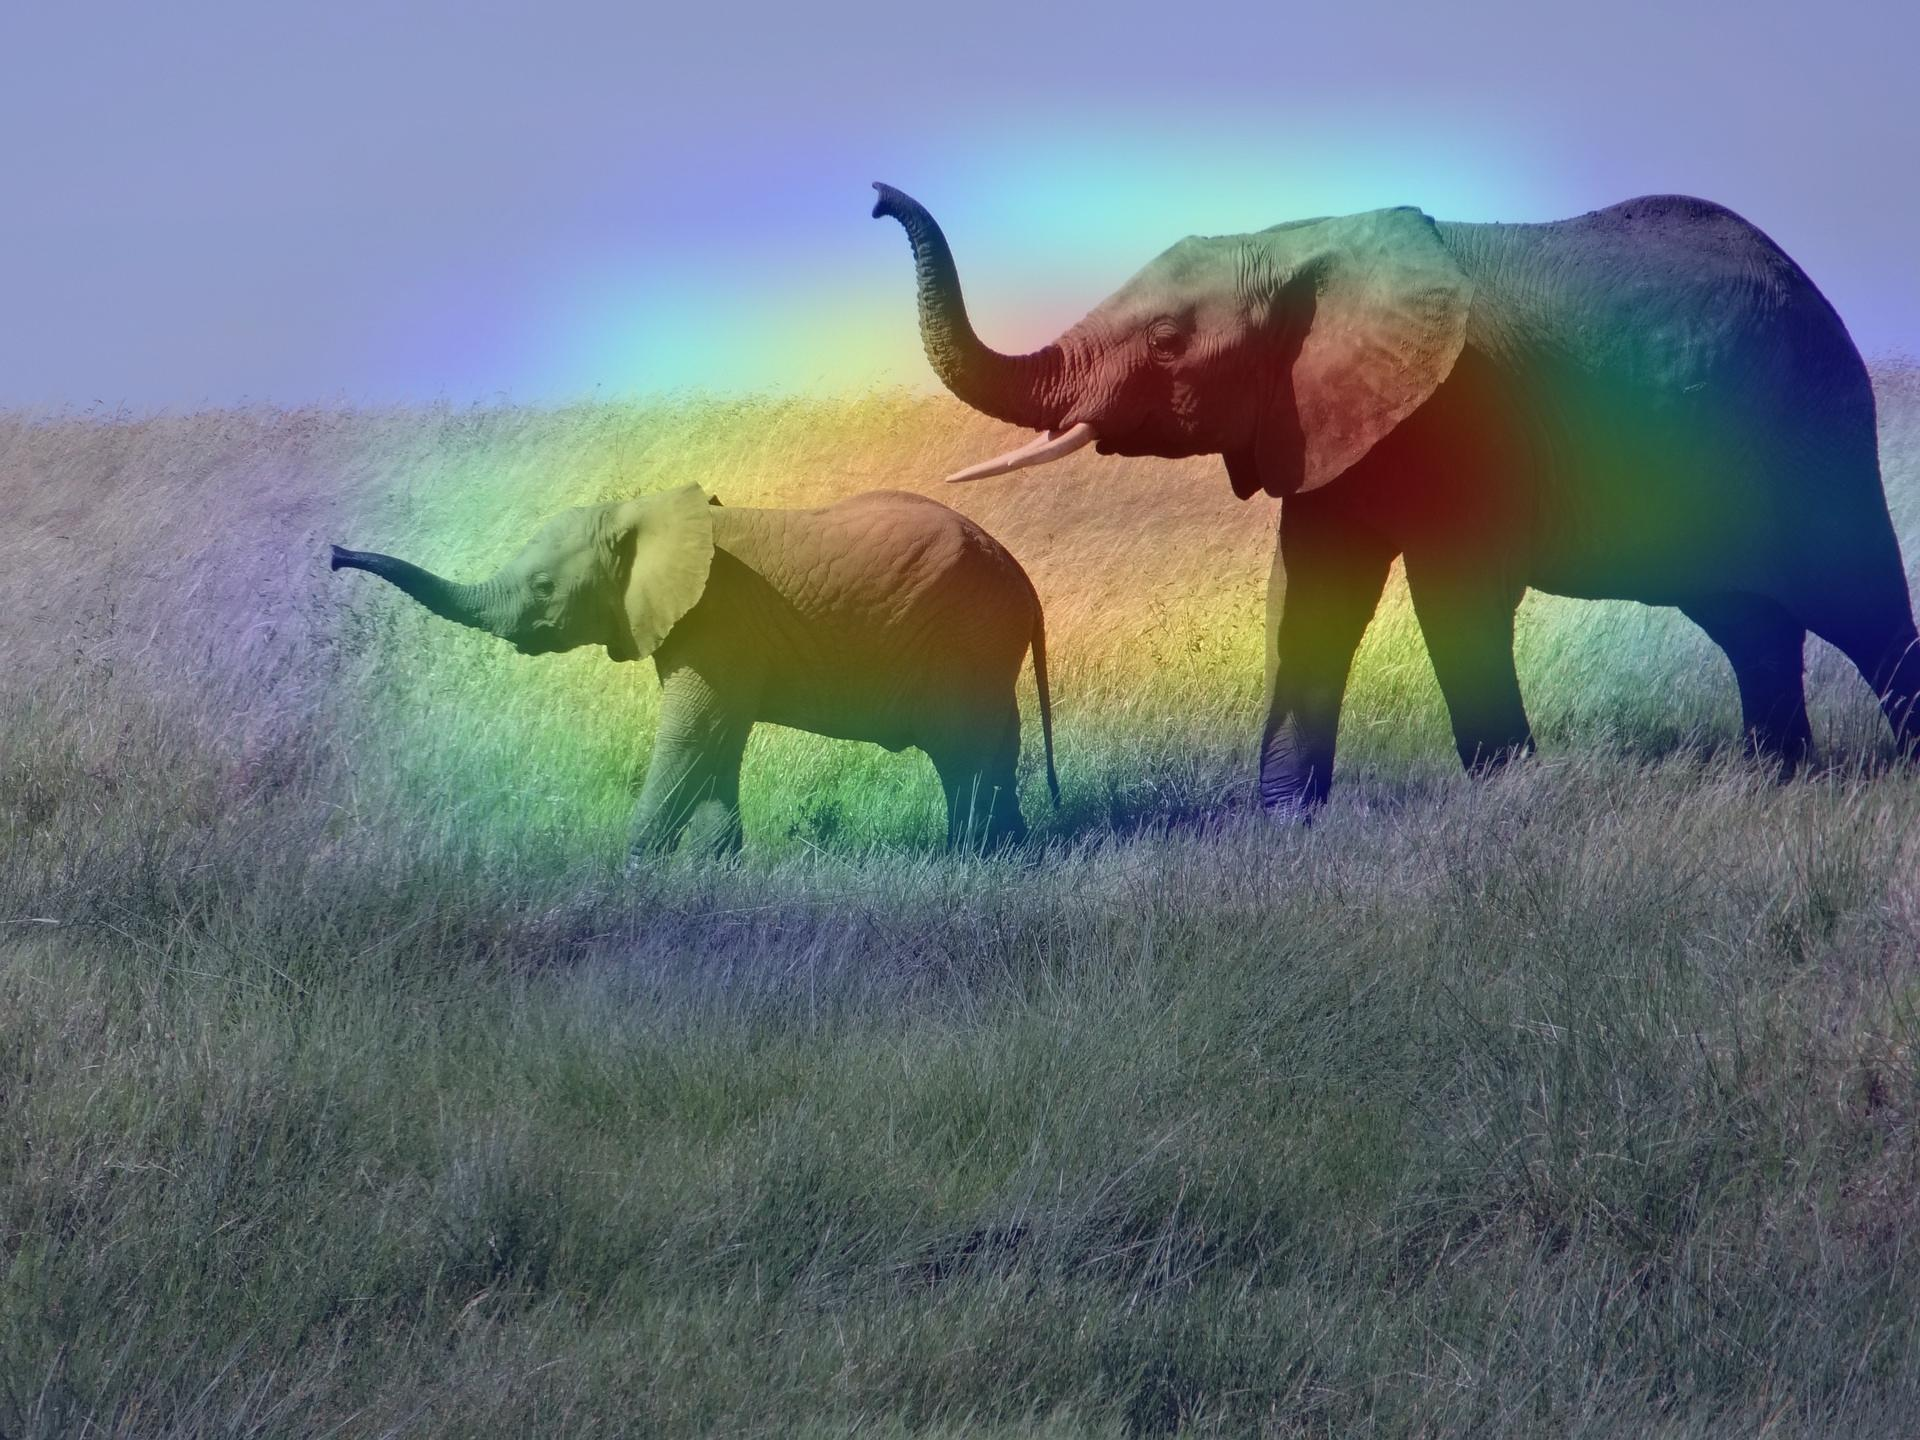

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

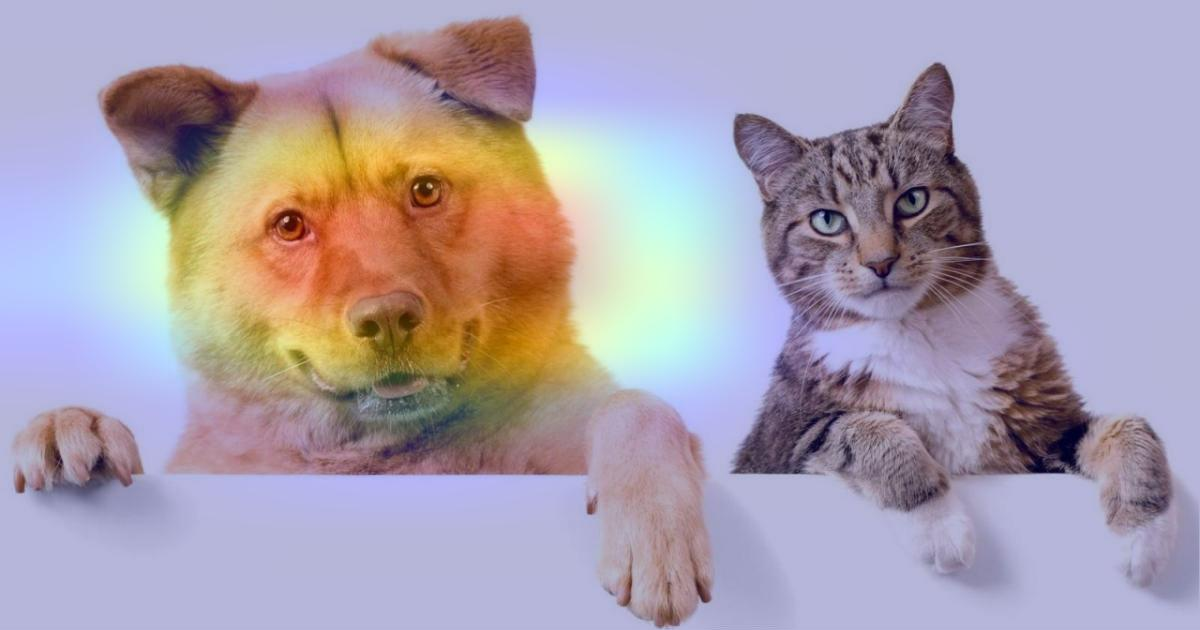

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

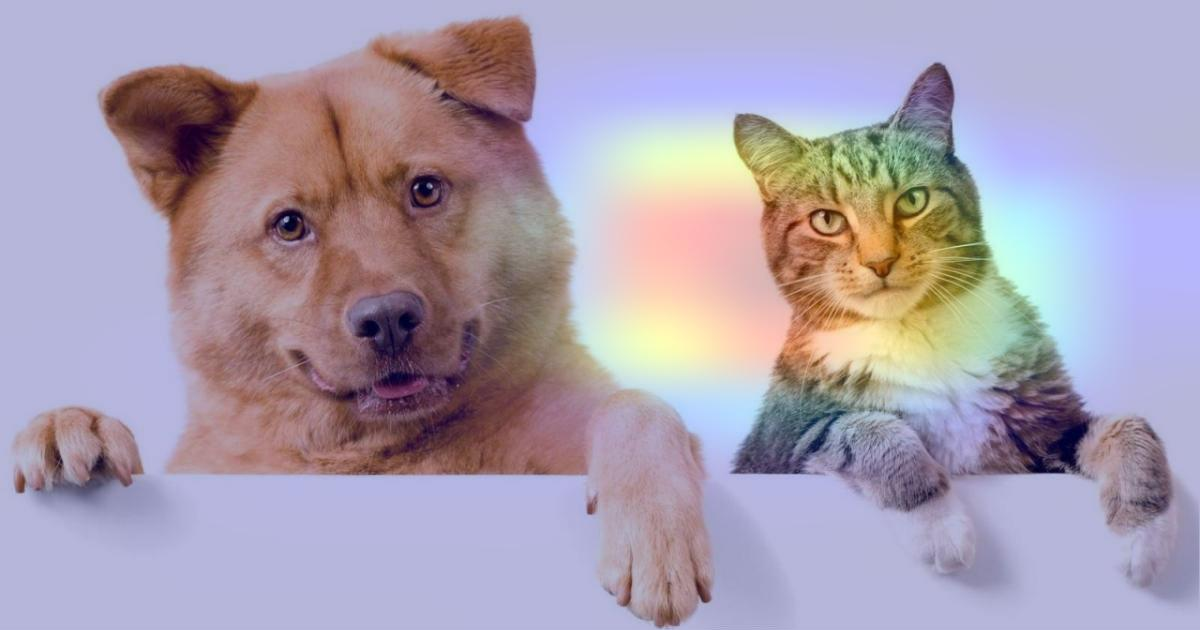

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)